In [100]:
using Printf
using Plots
using JuMP
using Cbc
using StatPlots
using DataFrames

┌ Info: Recompiling stale cache file C:\Users\vitoria\.julia\compiled\v1.0\DataFrames\AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1190


## Funções auxiliares

In [2]:
function capacidade(X, G)
    capacidade = zeros(12)
    for i in 1:12
        for j in 1:length(G)
            if round(Int, X[j, i])==1
                capacidade[i]+=G[j]
            end
        end
    end
    c = sum(G)
    for i in 1:12
        capacidade[i] = c-capacidade[i]
    end
    return capacidade
end

capacidade (generic function with 1 method)

In [67]:
function cvar(θ, S, Dl)
    CVaR = zeros(12)
    VaR = ceil(Int, θ*S)
    for i in 1:12
        CVaR[i] = sum(sort(Dl[i, S-VaR+1:end]))/(VaR)
    end
    return CVaR
end

cvar (generic function with 1 method)

# Problema de agendamento de manutenção

In [5]:
# Capacidade de cada usina
G = [10,5,20,18,23,32,7,12,10,20,17,32,12,13,17];
# Demanda de cada mês
D = [238,220,187,175,135,127,144,165,193,205,213,233];

## 1) Problema inicial

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [6]:
function modelo1(G, d)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α);
    @objective(m, Min, α);
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
      myCons1[j] = @constraint(m, α >= sum(G[i]*(1-x[i,j]) for i=1:N) - d[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
      myCons2[j] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= d[j])
    end
    @time status = solve(m)
    return m, getvalue(x)
end

modelo1 (generic function with 1 method)

In [8]:
m1, X1 = modelo1(G, D);

  2.183440 seconds (692.29 k allocations: 34.155 MiB, 1.09% gc time)


In [11]:
capacidade1 = capacidade(X1, G)
aux = hcat(D, capacidade2);

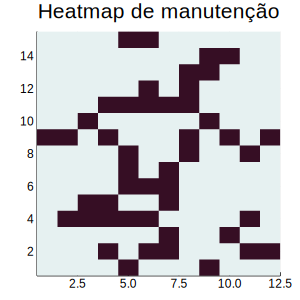

In [72]:
heatmap(X1, color = :dense, size=(300,300), legend=false, title="Heatmap de manutenção")

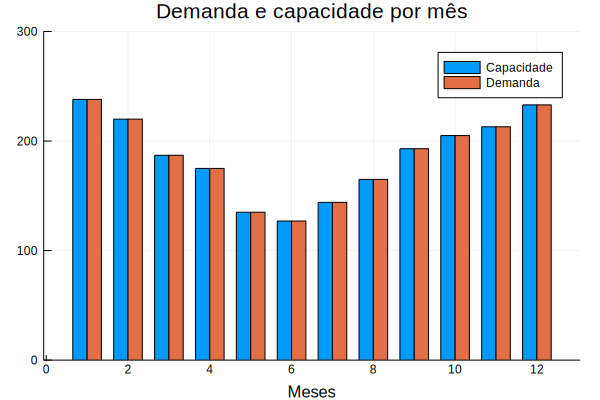

In [22]:
ctg = repeat(["Demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", title = "Demanda e capacidade por mês", 
    bar_position = :dodge, bar_width=0.7, ylims = (0,300))

## 2) Cenários de renováveis e demanda líquida com otimização de valor esperado

<center>$min$ $\sum_s \alpha_t^s\cdot \frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_t^s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [61]:
#Quantidade de cenários
S = 10;
#Capacidade de renováveis
R = rand(1:100,12, S);
Dl = D;
for i in 2:S
    Dl = hcat(Dl, D)
end
#Demanda líquida
Dl = Dl-R;

In [62]:
function modelo2(G, Dl)
    T = 12;
    N = length(G);
    S = size(Dl)[2];
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:S])
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons1[j,k] = @constraint(m, α[k] >= sum(G[i]*(1-x[i,j]) for i=1:N) - Dl[j,k])
        end
    end
    @constraintref myCons2[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons2[j,k] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= Dl[j,k])
        end
    end
    @objective(m, Min, sum(α[k] for k=1:S)/S);
    @time status = solve(m)
    return m, getvalue(x)
end

modelo2 (generic function with 1 method)

In [63]:
m2, X2 = modelo3(G, Dl);

  0.110373 seconds (71 allocations: 280.023 KiB)


In [64]:
capacidade2 = capacidade(X2, G)
valor_esperado = [sum(Dl[i,:])/S for i in 1:12]
maior_demanda =[sort(Dl[i,:])[end] for i in 1:12]
aux = hcat(valor_esperado, maior_demanda, capacidade2);

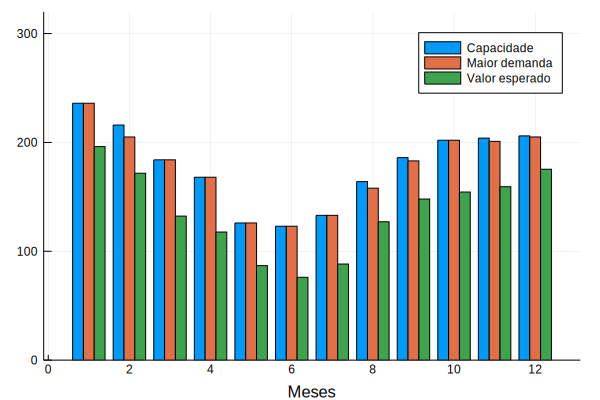

In [65]:
ctg = repeat(["Valor esperado", "Maior demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", bar_position = :dodge, bar_width=0.8, ylims = (0,320))

## 3) CVaR determinístico nas restrições

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-CVaR_\theta(Dliq_t^s)$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [68]:
θ = 0.4;
CVaR = cvar(θ, S, Dl);

## 4) CVaR como problema de otimização na função objetivo

<center>$min$ $CVaR_\theta(\alpha)$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $C$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

## 5) Combinação convexa de Valor esperado e CVaR

<center>$min$ $\lambda \cdot CVaR_\theta(\alpha) + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $\lambda \cdot C + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

## 6) Minimizar custo total

<center>$min$ $\sum_t \alpha^t + \sum_{i,t}c_i\cdot g_i^t + \sum_{i,t} k_i \cdot x_i^t$</center>

<center>$s.a.$ $\alpha^t$ $\geq$ $\sum_i g_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i g_i^t \geq D_t$ $\forall t$</center>

<center>$g_i^t \leq G_i\cdot (1-x_i^t)$</center>

In [69]:
# Custo de geração
c = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15];
# Custo de manutenção
k = [1,1,1,1,1,1,1,1,1,2,2,2,2,1,1];

In [70]:
function modelo6(G, D, c, k)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:T])
    @variable(m, g[1:N,1:T] >= 0)
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
        myCons1[j] = @constraint(m, α[j] >= sum(g[i,j] for i=1:N) - D[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
        myCons2[j] = @constraint(m, sum(g[i,j] for i=1:N) >= D[j])
    end
    @constraintref myCons3[1:N,1:T]
    for i = 1:N
        for j = 1:T
            myCons3[i,j] = @constraint(m, g[i,j]<=G[i]*(1-x[i,j]))
        end
    end
    @objective(m, Min, sum(α[j] for j=1:T)+sum(sum(c[i]*g[i,j] for i=1:N) for j=1:T)+sum(sum(k[i]*x[i,j] 
                for j=1:T) for i=1:N));
    @time status = solve(m)
    αa = getvalue(α)
    ga = getvalue(g)
    xa = getvalue(x)
    custo = [αa[j]+sum(c[i]*ga[i,j] for i=1:N)+sum(k[i]*xa[i,j] for i=1:N) for j = 1:T]
    return m, ga, xa, custo
end

modelo6 (generic function with 1 method)

In [71]:
m6, g6, X6, custo = modelo6(G,D,c,k);

  0.151892 seconds (66 allocations: 111.758 KiB)


In [108]:
cap = convert(DataFrame, g6)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0
2,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,20.0,20.0,20.0,20.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0
4,18.0,18.0,18.0,18.0,18.0,0.0,18.0,18.0,18.0,18.0,18.0,18.0
5,23.0,23.0,23.0,23.0,23.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
6,32.0,32.0,32.0,32.0,0.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0
8,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0,12.0,12.0,12.0
9,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


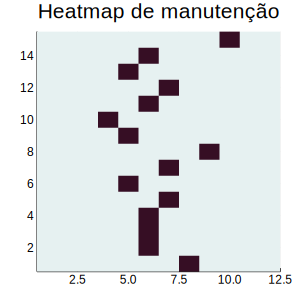

In [73]:
heatmap(X6, color = :dense, size=(300,300), legend=false, title="Heatmap de manutenção")

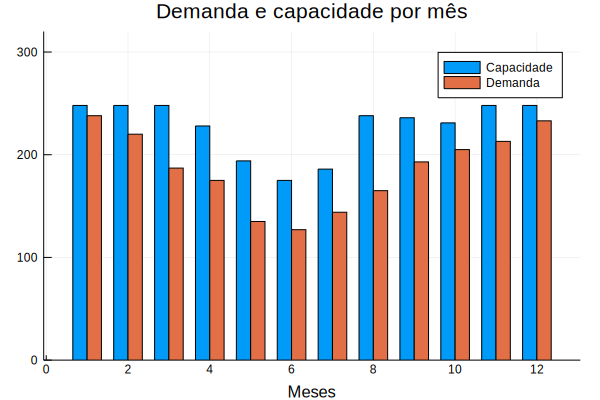

In [77]:
capacidade6 = capacidade(X6, G)
aux = hcat(D, capacidade6)
ctg = repeat(["Demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", title = "Demanda e capacidade por mês", 
    bar_position = :dodge, bar_width=0.7, ylims = (0,320))

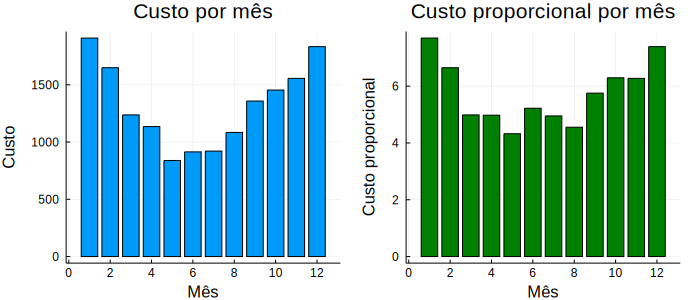

In [97]:
custo_mensal = bar(custo, legend=false, title = "Custo por mês", xlabel="Mês", ylabel="Custo")
cp = [custo[i]/capacidade6[i] for i in 1:12]
custo_proporcional = bar(cp, legend=false, title = "Custo proporcional por mês", xlabel="Mês", ylabel="Custo proporcional",
    color="green")
plot(custo_mensal, custo_proporcional, size=(700, 300))